### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
#This installation command is to resolve issues with respect to efficient not being found in the initila build of segmentation modle sm 
!pip install -U git+https://github.com/qubvel/segmentation_models
#uPGRADE SCKITI IMAGE
!pip install --upgrade scikit-image
#RESTART THE KERNEL POST INSTALLATION
#This is to resolve the dependency issues with skimage. 
!pip install numpy==1.17
!pip install ipdb

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: segmentation-models in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (1.0.0)
Requirement not upgraded as not directly required: keras-applications<=1.0.8,>=1.0.7 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from segmentation-models) (1.0.8)
Requirement not upgraded as not directly required: efficientnet==1.0.0 in /home/ec2-user/.local/lib/python3.6/site-packages (from segmentation-models) (1.0.0)
Requirement not upgraded as not directly required: image-classifiers==1.0.0 in /home/ec2-user/.local/lib/python3.6/site-packages (from segmentation-models) (1.0.0)
Requirement not upgraded as not directly required: numpy>=1.9.1 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from keras-applications<=1.0.8,>=1.0.7->segmentation-model

  Running setup.py bdist_wheel for segmentation-models ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-03i0j1p0/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
  Found existing installation: segmentation-models 1.0.0
    Uninstalling segmentation-models-1.0.0:
      Successfully uninstalled segmentation-models-1.0.0
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: scikit-image in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (0.16.2)
Requirement not upgraded as not directly required: matplotlib!=3.0.0,>=2.0.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-image) (3.0.3)
Requirement not upgraded as not directly required: pillow>=4.3.0 in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (from scikit-im

In [5]:
#RESTART THE KERNEL POST INSTALLATION of cell above
import tensorflow as tf

In [6]:
import os
from sklearn.model_selection import train_test_split
import glob
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import imageio
import albumentations as A
import random
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [7]:
#Confirmation that GPU is in working order. 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

print(tf.test.gpu_device_name())

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

/device:GPU:0
[[22. 28.]
 [49. 64.]]


# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [8]:
TRAIN_DATA_DIR =r'/home/ec2-user/SageMaker/data/500_imgs/train/NIFTI_MR_256x256_png_256grey_lvl/t1dual_inphase'
VALID_DATA_DIR=r'/home/ec2-user/SageMaker/data/500_imgs/valid/NIFTI_MR_256x256_png_256grey_lvl/t1dual_inphase'
#TEST_DATA_DIR=r'/home/ec2-user/SageMaker/data/valid_data/1_pat_no_32/NIFTI_MR_512x512_png_256grey_lvl/t1dual_inphase'

In [9]:
x_train_dir = os.path.join(TRAIN_DATA_DIR, 'images')
y_train_dir = os.path.join(TRAIN_DATA_DIR, 'masks')

x_valid_dir = os.path.join(VALID_DATA_DIR, 'images')
y_valid_dir = os.path.join(VALID_DATA_DIR, 'masks')

#x_test_dir = os.path.join(TEST_DATA_DIR, 'source')
#y_test_dir = os.path.join(TEST_DATA_DIR, 'ground')

# Dataloader and utility functions 

In [10]:
# helper function for data visualization
def visualize(figdim=(30,30),**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=figdim)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = {'background':0,'liver':63,'r_kidney':126,'l_kidney':189,'spleen':252}
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES[cls.lower()] for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = imageio.imread(self.images_fps[i])#cv2.imread(self.images_fps[i])
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=np.expand_dims(image,axis=2)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

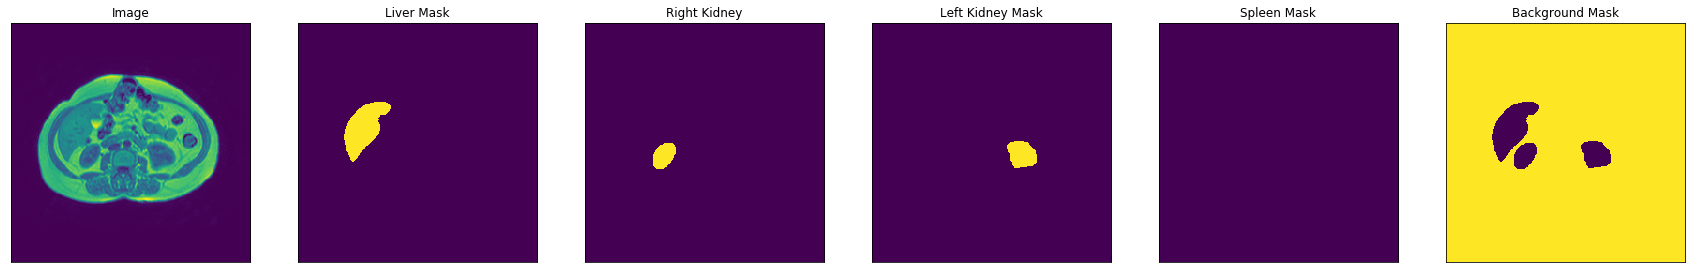

In [8]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['liver','r_kidney','l_kidney','spleen'])

image, mask = dataset[1] # get some sample
visualize(
    image=np.squeeze(image,axis=2), 
    liver_mask=mask[..., 0].squeeze(),
    right_kidney=mask[..., 1].squeeze(),
    left_kidney_mask=mask[..., 2].squeeze(),
    spleen_mask=mask[..., 3].squeeze(),
    background_mask=mask[..., 4].squeeze()
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [11]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(dim_sp=256):
    
    rand_int_alpha=random.uniform(0,3)
    if rand_int_alpha<=0.5:
        rand_int_sigma=random.uniform(0.1,rand_int_alpha)
    elif rand_int_alpha>=2:
        rand_int_sigma=random.uniform(rand_int_alpha/1.8,rand_int_alpha)
    else:
        rand_int_sigma=random.uniform(rand_int_alpha/1.8,rand_int_alpha)
    train_transform = [
        #A.RandomGridShuffle(p=0.4,grid=(8, 8)),
        A.ElasticTransform(p=0.9,alpha=rand_int_alpha,sigma=rand_int_sigma,border_mode=cv2.BORDER_REPLICATE), #,alpha_affine=20
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.RandomSizedCrop(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=90, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_REPLICATE),

        #A.PadIfNeeded(min_height=dim_sp, min_width=dim_sp, always_apply=True, border_mode=cv2.BORDER_REPLICATE),
        #A.RandomCrop(height=dim_sp, width=dim_sp, always_apply=True),

        A.OneOf(
            [
                A.IAASharpen(p=0.5),
                A.Blur(blur_limit=3, p=0.5)
            ],
            p=0.2,
        ),

        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_validation_augmentation(dim_sp=256):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Resize(height=dim_sp,width=dim_sp)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes=['liver','r_kidney','l_kidney','spleen'],
                 preprocessing=get_preprocessing(preprocess_input),
                 augmentation=get_training_augmentation())

train_dataloader = Dataloder(dataset, batch_size=5, shuffle=True)
plt.imshow(train_dataloader[1][0][0,:,:].squeeze())

In [ ]:
image, mask = dataset[0] # gt some sample
visualize(
    image=np.squeeze(image,axis=2),
    liver_mask=mask[..., 0].squeeze(),
    right_kidney=mask[..., 1].squeeze(),
    left_kidney_mask=mask[..., 2].squeeze(),
    spleen_mask=mask[..., 3].squeeze(),
    background_mask=mask[..., 4].squeeze()
)

# Segmentation model training

In [12]:
import segmentation_models as sm
import datetime
import itertools
from sklearn.utils import class_weight
import imageio
import numpy as np
import pickle
import ipdb
# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [13]:
BACKBONE = 'resnet101'#'efficientnetb3'densenet121
#BATCH_SIZE = 3
CLASSES = ['l_kidney','liver','r_kidney','spleen']#
class_weights='yes'
opt='adam'
#loss_func='dice_weighted_coeff'
grey_lvl=256
samp_size=500
str_time=str(datetime.datetime.now())[:10]
img_type='t1dual_inphase'
#batch_size=3
orgs='all_orgs'

#Model_name='t1dual_inphase_all_orgs_256greylvl_cls_wghts_yes_adam_opt_Btch_sze_3_softmax_dice_loss_12Oct19'
#LR = 0.0001
EPOCHS = 200
N=1
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
file_lst=os.listdir()
concat_arr=None
for file in enumerate(file_lst):
    
    trl_img=imageio.imread(file[1])
    trl_img_flt=trl_img.flatten()
    
    if concat_arr is None:
        concat_arr=trl_img_flt
    else:
        concat_arr=np.vstack((concat_arr,trl_img_flt))

        


In [46]:
class_weight.compute_class_weight('balanced', concat_arr.flatten())

array([ 0.20918984,  6.33715245, 58.531652  , 56.95835365, 36.74841572])

In [ ]:
np.unique(concat_arr.flatten())

In [14]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'


In [15]:
# define optomizer


# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
#dice_loss = sm.losses.DiceLoss(class_weights=dict_class_wghts) #100.02,,99.52, 55.957, #np.array([152.74,24.05,136.17,91.74,0.97])


#focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
#categorical_loss=sm.losses.CategoricalCELoss(class_weights=np.array([152.74,24.05,136.17,91.74,0.97]))
#total_loss = categorical_loss #dice_loss# + (1 * 

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [16]:
dict_class_wghts={0:0.2,63:6.33,126:58.531652, 189:56.95, 252:36.748}

In [16]:
dice_class_wghts=np.array([6.33,58.53,56.95,36.748,0.2])
dice_class_wghts_perc=dice_class_wghts/np.sum(dice_class_wghts)
dice_class_wghts_perc

array([0.03987201, 0.36867433, 0.35872208, 0.2314718 , 0.00125978])

In [17]:
train_dataset = Dataset(
        x_train_dir, 
        y_train_dir, 
        classes=CLASSES,
        preprocessing=get_preprocessing(preprocess_input),
        augmentation=get_training_augmentation())

/home/ec2-user/.local/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2875: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [18]:
#0.001, remove learning rate process for grid search. 
grd_srch={'Lrn_Rate':[0.0003], #,0.001,0.01,0.1,,0.001
          'Btch_Sz':[3], #3
          'loss_f':[sm.losses.CategoricalFocalLoss()]}
#3, sm.losses.CategoricalCELoss(class_weights=dice_class_wghts_perc)]
#sm.losses.DiceLoss(class_weights=dice_class_wghts_perc)
allNames = sorted(grd_srch)
grd_srch_combos = list(itertools.product(*(grd_srch[Name] for Name in allNames)))
grd_srch_combos


[(3,
  0.0003,
  <segmentation_models.losses.CategoricalFocalLoss at 0x7f612ac69fd0>)]

In [19]:


for no,combos in enumerate(grd_srch_combos):
    
    no+=1
    
    #if no==2:
     #   continue
    #else:
    
    #if no%2==0:
    loss_func='focal_loss_all_cls_idx'
        # define callbacks for learning rate scheduling and best checkpoints saving
    optim = keras.optimizers.Adam(combos[1])

    Model_name=img_type+'_'+orgs+'_grey_lvl_'+str(grey_lvl)+'_optm_'+opt+'_loss_'+loss_func+'_trn_samp_sz_'+str(samp_size)+'_btch_sz_'+str(combos[0])+'_lr_'+str(combos[1])+'_time_'+str_time

    callbacks = [keras.callbacks.ModelCheckpoint('./'+Model_name+'.h5', save_weights_only=True, save_best_only=True, mode='min'),
                 keras.callbacks.ReduceLROnPlateau(),
                 keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',min_delta=0.0001, verbose=1,patience=90)]
    #else:
     #   loss_func='focal_loss_cls_idx_no_bkgrnd'
        
            # define callbacks for learning rate scheduling and best checkpoints saving
      #  optim = keras.optimizers.Adam(combos[1])

      #  Model_name=img_type+'_'+orgs+'_grey_lvl_'+str(grey_lvl)+'_optm_'+opt+'_loss_'+loss_func+'_trn_samp_sz_'+str(samp_size)+'_btch_sz_'+str(combos[0])+'_lr_'+str(combos[1])+'_time_'+str_time

        
      #  callbacks = [keras.callbacks.ModelCheckpoint('./'+Model_name+'.h5', save_weights_only=True, save_best_only=True, mode='min'),
      #               keras.callbacks.ReduceLROnPlateau(),
      #               keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',min_delta=0.0001, verbose=1,patience=60)]

    # Dataset for train images
    train_dataset = Dataset(
        x_train_dir, 
        y_train_dir, 
        classes=CLASSES,
        preprocessing=get_preprocessing(preprocess_input),
        augmentation=get_training_augmentation())

    # Dataset for validation images
    valid_dataset = Dataset(
        x_valid_dir, 
        y_valid_dir, 
        classes=CLASSES,
        preprocessing=get_preprocessing(preprocess_input),
        augmentation=get_validation_augmentation())

    #Dataloader method for analysis 
    train_dataloader = Dataloder(train_dataset, batch_size=combos[0], shuffle=True)
    valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)


    #create model
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation,
                    encoder_weights=None, input_shape=(None, None, N))



    #Comle model based on method. 
    model.compile(optim, combos[2], metrics)
    
    model_list=os.listdir()
    
    model_nm=Model_name+'.h5'
    #If model name in model list load weights for analysis
    #ipdb.set_trace()
    if model_nm in model_list:
        print('model_weights loaded')
        model.load_weights(model_nm)

    
    # train model
    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=valid_dataloader, 
        validation_steps=len(valid_dataloader),
    )
    history_nm=Model_name+'_history'
    
    if history_nm in os.listdir():
        history_nm=history_nm+'_pt2'

    with open(history_nm, 'wb') as file_pi:

        pickle.dump(history.history, file_pi)


/home/ec2-user/.local/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2875: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "
W1106 15:26:19.602695 140057828476736 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1106 15:26:19.614628 140057828476736 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1106 15:26:19.615284 140057828476736 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:17

Epoch 1/200
165/165 [==============================] - 138s 835ms/step - loss: 0.1810 - iou_score: 0.1637 - f1-score: 0.1759 - val_loss: 0.0733 - val_iou_score: 0.5412 - val_f1-score: 0.5541
Epoch 2/200
165/165 [==============================] - 98s 593ms/step - loss: 0.0469 - iou_score: 0.3830 - f1-score: 0.4083 - val_loss: 0.0496 - val_iou_score: 0.6205 - val_f1-score: 0.6423
Epoch 3/200
165/165 [==============================] - 98s 593ms/step - loss: 0.0386 - iou_score: 0.4125 - f1-score: 0.4385 - val_loss: 0.0415 - val_iou_score: 0.6587 - val_f1-score: 0.6786
Epoch 4/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0352 - iou_score: 0.4246 - f1-score: 0.4504 - val_loss: 0.0335 - val_iou_score: 0.6694 - val_f1-score: 0.6886
Epoch 5/200
165/165 [==============================] - 98s 593ms/step - loss: 0.0318 - iou_score: 0.4342 - f1-score: 0.4589 - val_loss: 0.0362 - val_iou_score: 0.6470 - val_f1-score: 0.6662
Epoch 6/200
165/165 [============================

Epoch 44/200
165/165 [==============================] - 97s 591ms/step - loss: 0.0107 - iou_score: 0.6081 - f1-score: 0.6685 - val_loss: 0.0168 - val_iou_score: 0.7609 - val_f1-score: 0.7974
Epoch 45/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0108 - iou_score: 0.6194 - f1-score: 0.6815 - val_loss: 0.0164 - val_iou_score: 0.7656 - val_f1-score: 0.8011
Epoch 46/200
165/165 [==============================] - 98s 591ms/step - loss: 0.0107 - iou_score: 0.6284 - f1-score: 0.6885 - val_loss: 0.0166 - val_iou_score: 0.7601 - val_f1-score: 0.7950
Epoch 47/200
165/165 [==============================] - 97s 590ms/step - loss: 0.0106 - iou_score: 0.6166 - f1-score: 0.6751 - val_loss: 0.0175 - val_iou_score: 0.7494 - val_f1-score: 0.7860
Epoch 48/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0107 - iou_score: 0.6420 - f1-score: 0.7024 - val_loss: 0.0162 - val_iou_score: 0.7577 - val_f1-score: 0.7924
Epoch 49/200
165/165 [=======================

Epoch 87/200
165/165 [==============================] - 98s 593ms/step - loss: 0.0094 - iou_score: 0.6994 - f1-score: 0.7583 - val_loss: 0.0121 - val_iou_score: 0.7826 - val_f1-score: 0.8183
Epoch 88/200
165/165 [==============================] - 98s 591ms/step - loss: 0.0084 - iou_score: 0.7010 - f1-score: 0.7604 - val_loss: 0.0119 - val_iou_score: 0.7625 - val_f1-score: 0.8007
Epoch 89/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0089 - iou_score: 0.6965 - f1-score: 0.7600 - val_loss: 0.0114 - val_iou_score: 0.7910 - val_f1-score: 0.8242
Epoch 90/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0086 - iou_score: 0.7013 - f1-score: 0.7619 - val_loss: 0.0127 - val_iou_score: 0.7875 - val_f1-score: 0.8226
Epoch 91/200
165/165 [==============================] - 98s 591ms/step - loss: 0.0086 - iou_score: 0.7052 - f1-score: 0.7647 - val_loss: 0.0118 - val_iou_score: 0.7884 - val_f1-score: 0.8226
Epoch 92/200
165/165 [=======================

Epoch 130/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0082 - iou_score: 0.7339 - f1-score: 0.7942 - val_loss: 0.0135 - val_iou_score: 0.7849 - val_f1-score: 0.8188
Epoch 131/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0071 - iou_score: 0.7512 - f1-score: 0.8101 - val_loss: 0.0138 - val_iou_score: 0.7847 - val_f1-score: 0.8184
Epoch 132/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0074 - iou_score: 0.7469 - f1-score: 0.8057 - val_loss: 0.0140 - val_iou_score: 0.7815 - val_f1-score: 0.8152
Epoch 133/200
165/165 [==============================] - 98s 593ms/step - loss: 0.0070 - iou_score: 0.7455 - f1-score: 0.8032 - val_loss: 0.0144 - val_iou_score: 0.7784 - val_f1-score: 0.8123
Epoch 134/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0079 - iou_score: 0.7269 - f1-score: 0.7852 - val_loss: 0.0141 - val_iou_score: 0.7835 - val_f1-score: 0.8171
Epoch 135/200
165/165 [=================

Epoch 173/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0079 - iou_score: 0.7222 - f1-score: 0.7806 - val_loss: 0.0140 - val_iou_score: 0.7892 - val_f1-score: 0.8229
Epoch 174/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0073 - iou_score: 0.7410 - f1-score: 0.7989 - val_loss: 0.0141 - val_iou_score: 0.7808 - val_f1-score: 0.8143
Epoch 175/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0076 - iou_score: 0.7342 - f1-score: 0.7950 - val_loss: 0.0136 - val_iou_score: 0.7800 - val_f1-score: 0.8134
Epoch 176/200
165/165 [==============================] - 98s 592ms/step - loss: 0.0079 - iou_score: 0.7359 - f1-score: 0.7933 - val_loss: 0.0132 - val_iou_score: 0.7843 - val_f1-score: 0.8180
Epoch 177/200
165/165 [==============================] - 98s 593ms/step - loss: 0.0074 - iou_score: 0.7398 - f1-score: 0.7967 - val_loss: 0.0133 - val_iou_score: 0.7821 - val_f1-score: 0.8161
Epoch 178/200
165/165 [=================

## Reload model parameters

In [75]:
reload_model = sm.Unet(BACKBONE, classes=n_classes, activation=activation,
                encoder_weights=None, input_shape=(None, None, N))
reload_model.compile(optim, total_loss, metrics)

In [ ]:
import pickle
with open(Model_name+'_history_reload_pt2', 'wb') as file_pi:

    pickle.dump(history.history, file_pi)

## Reload partially trained model for further analysis

In [79]:
from keras.models import load_model
reload_model.load_weights('t1dual_inphase_all_orgs_grey_lvl_256_optm_adam_loss_categorical_cross_entropy_trn_samp_sz_250_btch_sz_3_time_2019-10-13.h5')



In [ ]:
# train model
history_reload = reload_model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

In [ ]:
#Load partly trained model

model = load_model('partly_trained.h5')

## Plot performance of model wrt to segmentation results

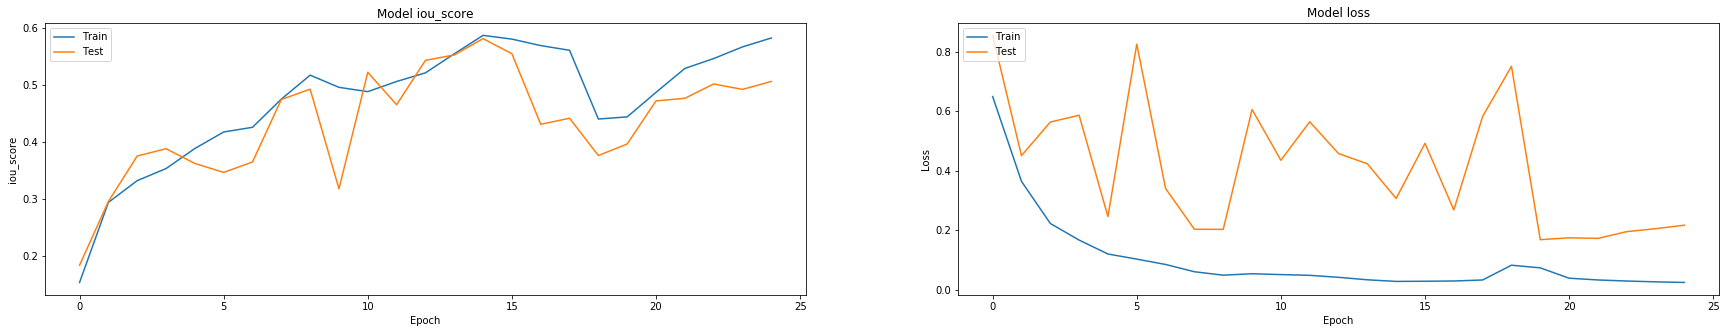

In [81]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

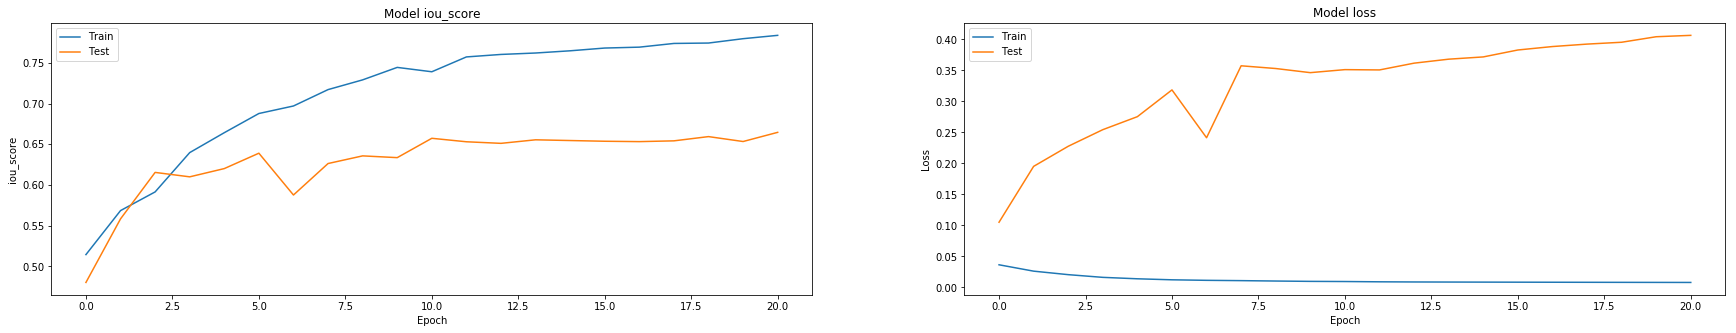

In [82]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_reload.history['iou_score'])
plt.plot(history_reload.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_reload.history['loss'])
plt.plot(history_reload.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [83]:
with open(Model_name+'_pt2_history', 'wb') as file_pi:
    pickle.dump(history_reload.history, file_pi)

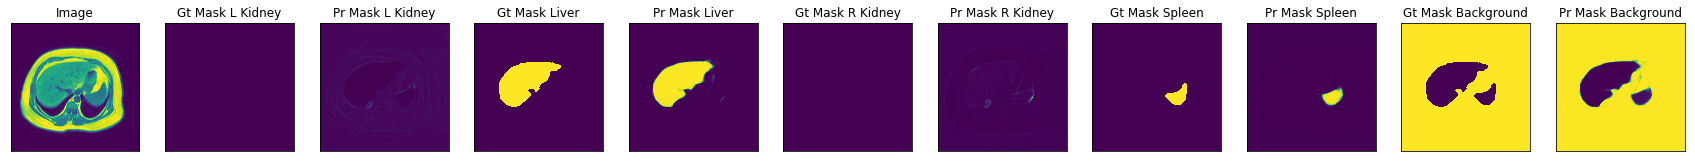

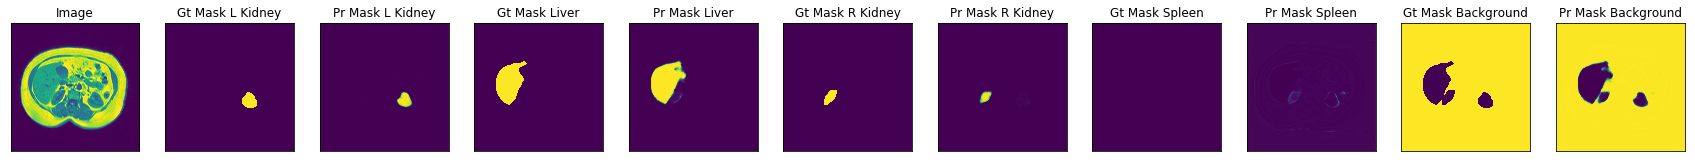

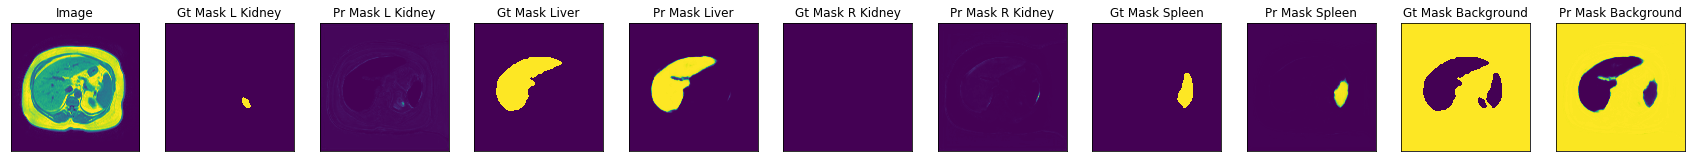

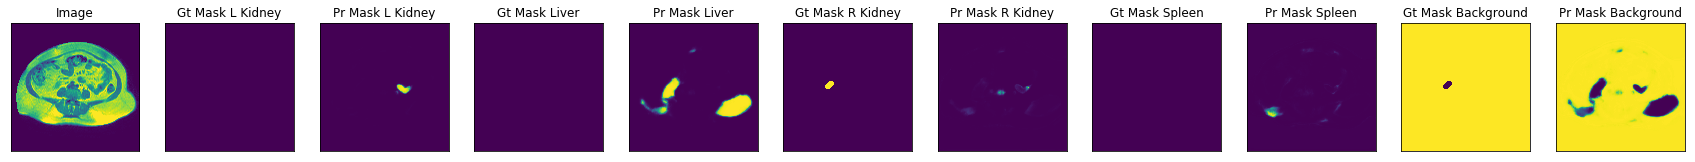

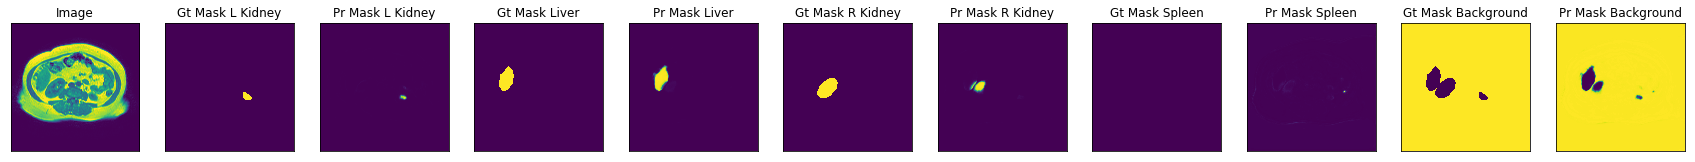

In [31]:
n = 5
import random
random.seed(49)
ids = np.random.choice(np.arange(len(valid_dataset)), size=n)

for i in ids:
    
    image, gt_mask = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    pr_mask_sqz=pr_mask.squeeze()
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask_l_kidney=gt_mask[:,:,0],
        pr_mask_l_kidney=pr_mask_sqz[:,:,0],
        gt_mask_liver=gt_mask[:,:,1],
        pr_mask_liver=pr_mask_sqz[:,:,1],
        gt_mask_r_kidney=gt_mask[:,:,2],
        pr_mask_r_kidney=pr_mask_sqz[:,:,2],
        gt_mask_spleen=gt_mask[:,:,3],
        pr_mask_spleen=pr_mask_sqz[:,:,3],
        gt_mask_background=gt_mask[:,:,4],
        pr_mask_background=pr_mask_sqz[:,:,4],
    )

In [41]:
gt_mask.shape

(512, 512, 5)

In [ ]:
plt.imshow()

In [42]:
pr_mask_sqz=pr_mask.squeeze()
pr_mask_sqz.shape

(512, 512, 5)

In [37]:
image.squeeze().shape

(512, 512)

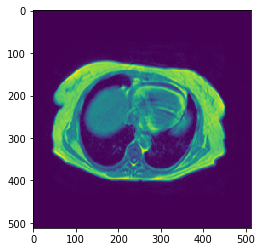

In [34]:
plt.imshow(image.squeeze())


# Model Evaluation

In [32]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

/home/ec2-user/.local/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2567: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [72]:
cd segmentation_models/examples/

/home/ec2-user/SageMaker/segmentation_models/examples


In [73]:
# load best weights
model.load_weights('t1dual_inphase_all_orgs_256greylvl_cls_wghts_yes_adam_opt_Btch_sze_3_softmax_focal_loss.h5') 

NameError: name 'glob' is not defined

In [33]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.021301
mean iou_score: 0.75232
mean f1-score: 0.79394


# Visualization of results on test dataset

28


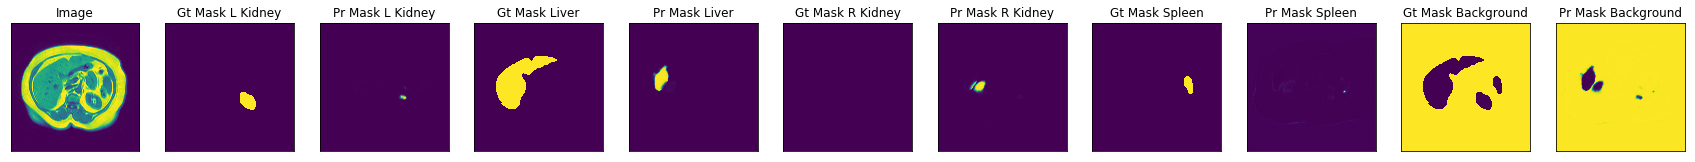

3


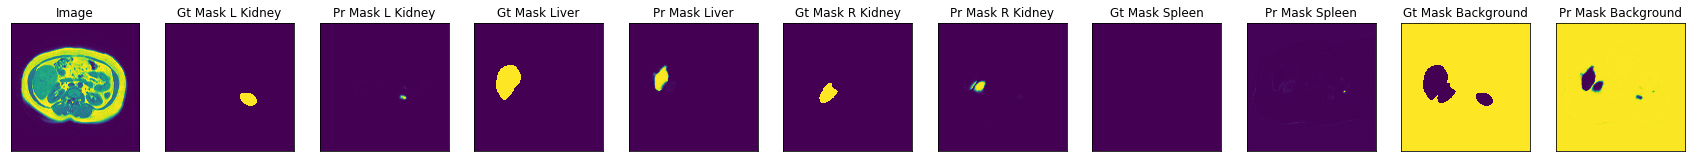

29


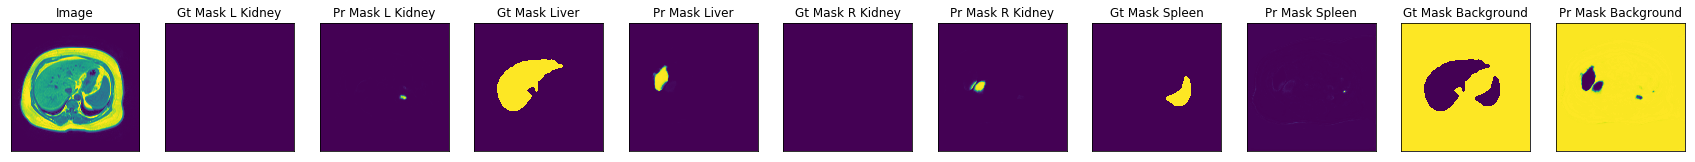

3


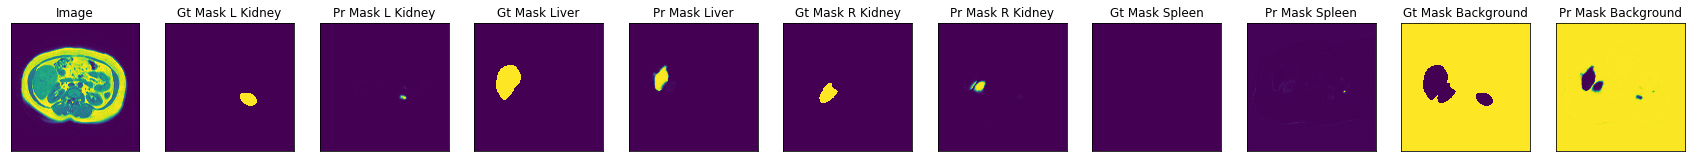

13


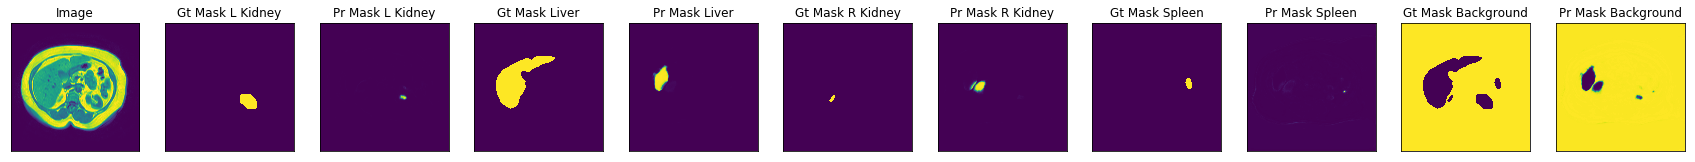

In [37]:
n = 5
import random
random.seed(15)
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    print(i)
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask_l_kidney=gt_mask[:,:,0],
        pr_mask_l_kidney=pr_mask_sqz[:,:,0],
        gt_mask_liver=gt_mask[:,:,1],
        pr_mask_liver=pr_mask_sqz[:,:,1],
        gt_mask_r_kidney=gt_mask[:,:,2],
        pr_mask_r_kidney=pr_mask_sqz[:,:,2],
        gt_mask_spleen=gt_mask[:,:,3],
        pr_mask_spleen=pr_mask_sqz[:,:,3],
        gt_mask_background=gt_mask[:,:,4],
        pr_mask_background=pr_mask_sqz[:,:,4],
    )